## Analysis Testing Type II: Leave-One-Year-Out (LOYO)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.objects as so
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
from sklearn.decomposition import PCA

import xgboost as xgb

import shap

import joblib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Preprocessing


In [2]:
LATE_BOOT_DATES_2021 = ["2021-06-14", "2021-06-23", "2021-06-30", "2021-07-28"]
LATE_BOOT_DATES_2022 = ["2022-06-09", "2022-06-17", "2022-06-25", "2022-07-19"]

# load 2021 (training) and 2022 (testing)
dfTrain = pd.read_csv("../../Datasets/2021/Dataset_2021.csv")
dfTest = pd.read_csv("../../Datasets/2022/Dataset_2022.csv")

dfTrain = dfTrain.sort_values(by=["Date", "Plot_Number"])
dfTest = dfTest.sort_values(by=["Date", "Plot_Number"])

# remove missing yield
dfTrain = dfTrain[dfTrain["Yield"].notna()]
dfTest = dfTest[dfTest["Yield"].notna()]

# Only keep dates that occur on/before late booting stage
dfTrain["Date"] = pd.to_datetime(dfTrain["Date"]).dt.strftime("%Y-%m-%d")
dfTrain = dfTrain[dfTrain["Date"].isin(LATE_BOOT_DATES_2021)]
dfTest["Date"] = pd.to_datetime(dfTest["Date"]).dt.strftime("%Y-%m-%d")
dfTest = dfTest[dfTest["Date"].isin(LATE_BOOT_DATES_2022)]

# remove vegetation fraction
dfTrain.drop("Vegetation_Fraction", axis=1, inplace=True)

# remove new indices from 2022
dfTest.drop(["DOY", "BNDVI", "LCI", "LAI"], axis=1, inplace=True)

# scale features
scaler = StandardScaler()
dfTrain.iloc[:, 17:] = scaler.fit_transform(dfTrain.iloc[:, 17:])

# standardize test data
dfTest.iloc[:, 16:] = scaler.transform(dfTest.iloc[:, 16:])

dfUavTrain = dfTrain.iloc[:, 17:]
# dfLabelsTrain = dfTrain.iloc[:, :17]
dfUavTest = dfTest.iloc[:, 16:]
dfLabelsTest = dfTest.iloc[:, :16]

# widen dataset
dfLongTestOriginal = pd.melt(
    dfTest.iloc[:, np.r_[0:8, 16 : len(dfTest.columns)]],
    id_vars=dfTest.iloc[:, 0:8],
    value_vars=dfTest.iloc[:, 16:],
)
dfWideTestOriginal = pd.pivot(
    dfLongTestOriginal,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()
dfWideTestOriginal.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTestOriginal.columns.tolist()
]

del dfLongTestOriginal

### Load Models


In [5]:
# load baseline model
nullModel = joblib.load("../Baseline_Model/Saved_Models/Baseline_LASSO")
nullModelExtra = joblib.load("../Baseline_Model/Saved_Models/Baseline_XGBoost")

# load architecture 1 models
pcaEmbedding = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_1/Saved_Models/PCA_EMBEDDING"
)
h1a1m1 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_1/Saved_Models/H1A1M1"
)
h1a1m2 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_1/Saved_Models/H1A1M2"
)

# load architecture 2 models
umapEmbedding = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_2/Saved_Models/UMAP_EMBEDDING"
)
h1a2m1 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_2/Saved_Models/H1A2M1"
)
h1a2m2 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_2/Saved_Models/H1A2M2"
)

### Transform and Preprocess Data (UMAP)


In [6]:
# transform test data into the new embedding
dfEmbeddingTestUMAP = pd.DataFrame(umapEmbedding.transform(dfUavTest))

# rename components
for i in range(0, len(dfEmbeddingTestUMAP.columns), 1):
    dfEmbeddingTestUMAP.rename(
        columns={dfEmbeddingTestUMAP.columns[i]: "UMAP_" + str(i + 1)},
        inplace=True,
    )

dfEmbeddingTestUMAP = pd.concat(
    [dfLabelsTest.reset_index(drop=True), dfEmbeddingTestUMAP], axis=1
)

# wide to long then long to wide
dfLongTestUMAP = pd.melt(
    dfEmbeddingTestUMAP.iloc[:, np.r_[0:8, 16 : len(dfEmbeddingTestUMAP.columns)]],
    id_vars=dfEmbeddingTestUMAP.iloc[:, 0:8],
    value_vars=dfEmbeddingTestUMAP.iloc[:, 16:],
)
dfWideTestUMAP = pd.pivot(
    dfLongTestUMAP,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTestUMAP.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTestUMAP.columns.tolist()
]

del dfLongTestUMAP, i

### Transform and Preprocess Data (PCA)


In [7]:
# transform test data into the new embedding
dfEmbeddingTestPCA = pd.DataFrame(pcaEmbedding.transform(dfUavTest))

# rename components
for i in range(0, len(dfEmbeddingTestPCA.columns), 1):
    dfEmbeddingTestPCA.rename(
        columns={dfEmbeddingTestPCA.columns[i]: "PCA_" + str(i + 1)},
        inplace=True,
    )

dfEmbeddingTestPCA = pd.concat(
    [dfLabelsTest.reset_index(drop=True), dfEmbeddingTestPCA], axis=1
)

# retain only first 10 PCs
dfEmbeddingTestPCA = dfEmbeddingTestPCA.loc[:, "Date":"PCA_10"]

# wide to long then long to wide
dfLongTestPCA = pd.melt(
    dfEmbeddingTestPCA.iloc[:, np.r_[0:8, 16 : len(dfEmbeddingTestPCA.columns)]],
    id_vars=dfEmbeddingTestPCA.iloc[:, 0:8],
    value_vars=dfEmbeddingTestPCA.iloc[:, 16:],
)
dfWideTestPCA = pd.pivot(
    dfLongTestPCA,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTestPCA.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTestPCA.columns.tolist()
]

del dfLongTestPCA, i

### Compute Predictions


In [8]:
results = dfWideTestOriginal.iloc[:, :7]

# Baseline Model
xTest = dfWideTestOriginal.iloc[:, 7:].values
yTest = dfWideTestOriginal["Yield"]
predictions = nullModel.predict(xTest)
results["Yield"] = yTest
results["Null_Model"] = predictions

print(
    f"Baseline Model (LASSO): "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

xTest = dfWideTestOriginal.iloc[:, 7:].values
dtest = xgb.DMatrix(xTest, label=yTest)
predictions = nullModelExtra.predict(dtest)
results["Null_Model_Extra"] = predictions

print(
    f"Baseline Model (XGBoost): "
    f"\nRMSE: {mean_squared_error(yTest, predictions, squared=False)}"
    f"\nMAE: {mean_absolute_error(yTest, predictions)}"
    f"\nMBE: {np.mean(predictions - yTest)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# model always predicting the mean
predictions = [
    dfTrain[dfTrain["Date"] == dfTrain["Date"].unique()[0]]["Yield"].mean()
] * len(yTest)
results["Constant_Model"] = predictions

print(
    f"CONSTANT MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# lasso pca
xTest = dfWideTestPCA.iloc[:, 7:].values
predictions = h1a1m1.predict(xTest)
results["Lasso_PCA"] = predictions

print(
    f"LASSO_PCA MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# xgboost pca
xTest = dfWideTestPCA.iloc[:, 7:].values
dtest = xgb.DMatrix(xTest, label=yTest)
predictions = h1a1m2.predict(dtest)
results["XGBoost_PCA"] = predictions

print(
    f"XGBOOST_PCA MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# lasso umap
xTest = dfWideTestUMAP.iloc[:, 7:].values
predictions = h1a2m1.predict(xTest)
results["Lasso_UMAP"] = predictions

print(
    f"LASSO_UMAP MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# xgboost umap
xTest = dfWideTestUMAP.iloc[:, 7:].values
dtest = xgb.DMatrix(xTest, label=yTest)
predictions = h1a2m2.predict(dtest)
results["XGBoost_UMAP"] = predictions

print(
    f"XGBOOST_UMAP MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

Baseline Model (LASSO): 
RMSE: 4.3553
MAE: 3.6783
MBE: -0.3718
MAPE: 0.5801
R^2: -0.2125
-----------------------------------------------------
Baseline Model (XGBoost): 
RMSE: 3.5803888514751807
MAE: 3.103312235969636
MBE: -0.41392069718045216
MAPE: 0.4425
R^2: 0.1806
-----------------------------------------------------
CONSTANT MODEL: 
RMSE: 4.1644
MAE: 3.604
MBE: 1.3029
MAPE: 0.6308
R^2: -0.1085
-----------------------------------------------------
LASSO_PCA MODEL: 
RMSE: 4.5444
MAE: 3.487
MBE: 1.4881
MAPE: 0.6289
R^2: -0.32
-----------------------------------------------------
XGBOOST_PCA MODEL: 
RMSE: 3.3836
MAE: 2.9135
MBE: -0.1685
MAPE: 0.4365
R^2: 0.2682
-----------------------------------------------------
LASSO_UMAP MODEL: 
RMSE: 10.4707
MAE: 8.2279
MBE: -7.567
MAPE: 0.9549
R^2: -6.0078
-----------------------------------------------------
XGBOOST_UMAP MODEL: 
RMSE: 3.4212
MAE: 2.8697
MBE: -0.4025
MAPE: 0.4169
R^2: 0.2519
-----------------------------------------------------


In [10]:
# Compute per cultivar metrics

# xgboost umap
for cultivar in dfTest["Rice_Cultivar"].unique():
    subset = dfWideTestUMAP[dfWideTestUMAP["Rice_Cultivar"] == cultivar]
    xTest = subset.iloc[:, 7:].values
    yTest = subset["Yield"]
    dtest = xgb.DMatrix(xTest, label=yTest)
    predictions = h1a2m2.predict(dtest)

    print(
        f"XGBOOST_UMAP MODEL ({cultivar}): "
        f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
        f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
        f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
        f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
        f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
        f"\n-----------------------------------------------------"
    )

XGBOOST_UMAP MODEL (RT7521FP): 
RMSE: 4.3585
MAE: 4.0245
MBE: -4.0245
MAPE: 0.2782
R^2: -7.5767
-----------------------------------------------------
XGBOOST_UMAP MODEL (NIL 43): 
RMSE: 1.7472
MAE: 1.5651
MBE: -1.4992
MAPE: 0.1629
R^2: -10.867
-----------------------------------------------------
XGBOOST_UMAP MODEL (Jefferson): 
RMSE: 3.3498
MAE: 2.9782
MBE: 2.8706
MAPE: 0.4711
R^2: -20.4956
-----------------------------------------------------
XGBOOST_UMAP MODEL (EMBRAPA 1200): 
RMSE: 0.794
MAE: 0.7735
MBE: 0.0309
MAPE: 0.1309
R^2: -0.242
-----------------------------------------------------
XGBOOST_UMAP MODEL (M-202): 
RMSE: 3.6035
MAE: 3.1316
MBE: 3.1316
MAPE: 0.9566
R^2: -1.1187
-----------------------------------------------------
XGBOOST_UMAP MODEL (WAB462-10-3-1): 
RMSE: 5.6744
MAE: 5.6549
MBE: 5.6549
MAPE: 1.6164
R^2: -210.5144
-----------------------------------------------------
XGBOOST_UMAP MODEL (Santee Gold): 
RMSE: 3.6745
MAE: 3.3353
MBE: -3.3353
MAPE: 0.3539
R^2: -88.949

Permutation explainer: 153it [00:15,  4.14it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


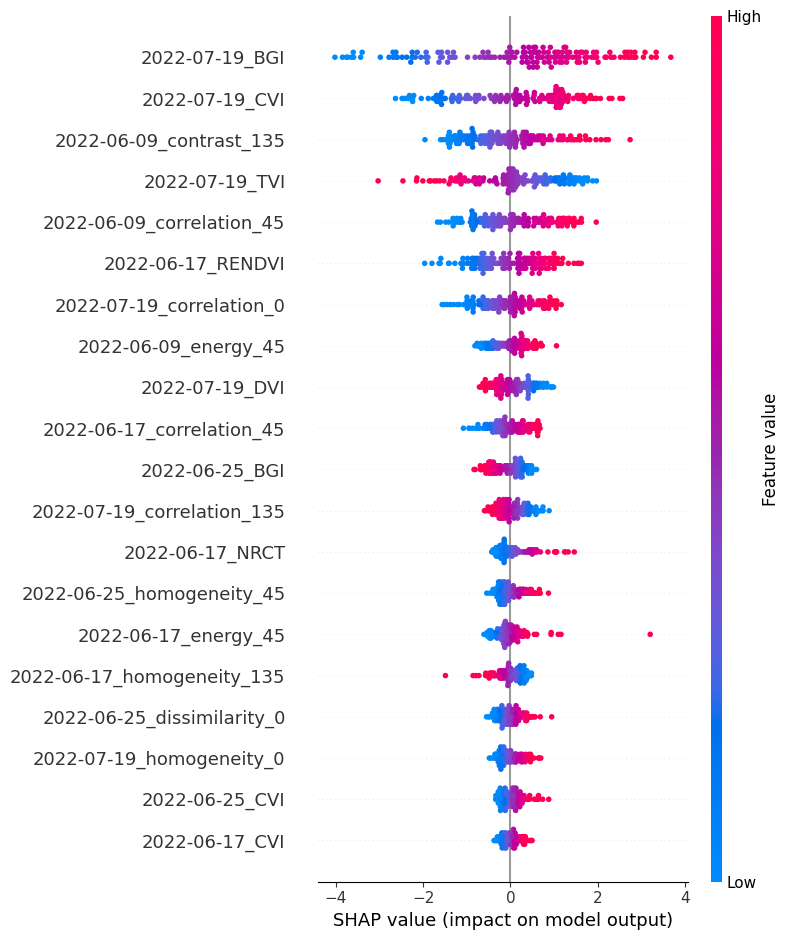

In [19]:
explainer = shap.Explainer(
    lambda x: nullModel.predict(x), dfWideTestOriginal.iloc[:, 7:].values
)
shapValues = explainer(dfWideTestOriginal.iloc[:, 7:].values)

shap.summary_plot(
    shapValues, plot_type="dot", feature_names=dfWideTestOriginal.columns[7:]
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


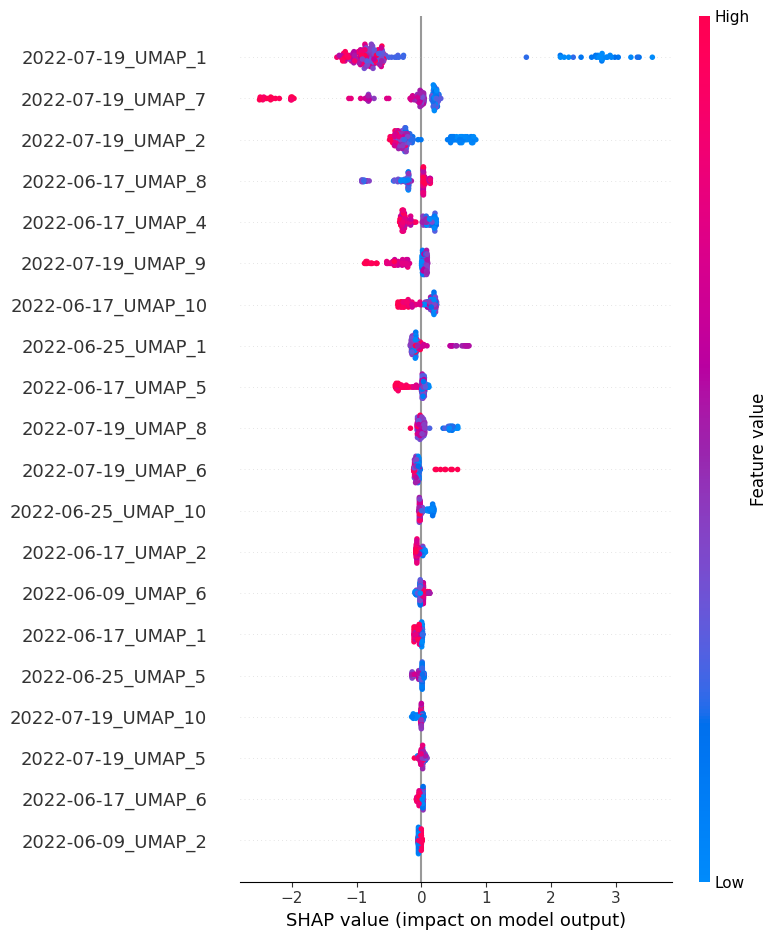

In [ ]:
explainer = shap.Explainer(h1a2m2)
shapValues = explainer(dfWideTestUMAP.iloc[:, 7:].values)

shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTestUMAP.columns[7:])

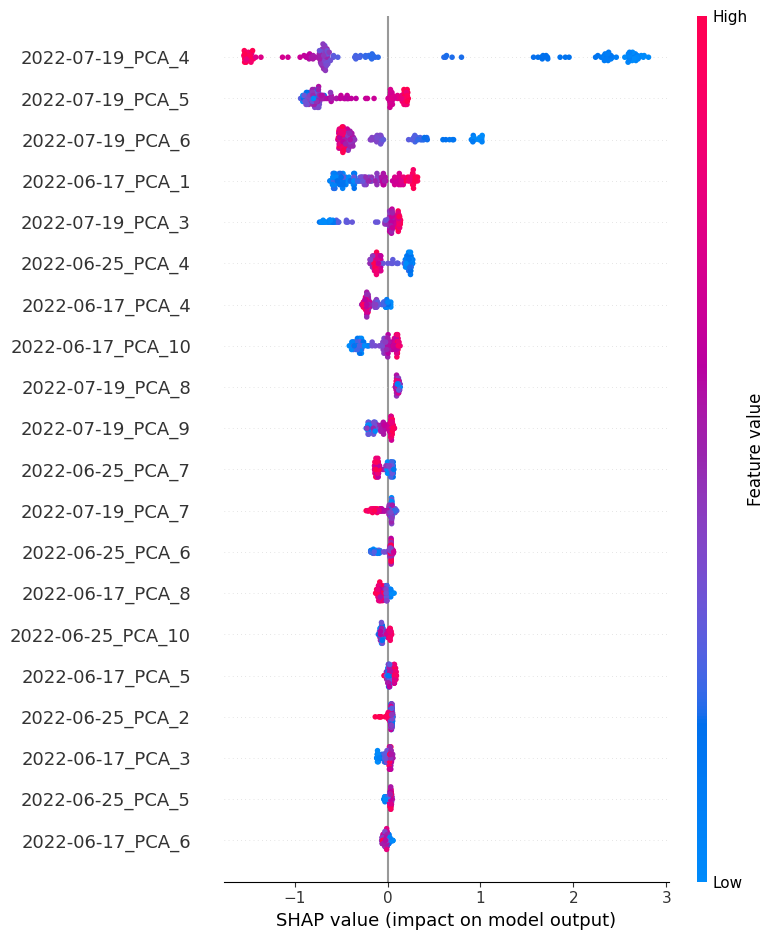

In [12]:
explainer = shap.Explainer(h1a1m2)
shapValues = explainer(dfWideTestPCA.iloc[:, 7:].values)

shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTestPCA.columns[7:])

### Export Results


In [16]:
results.to_csv("../Outputs/predictions.csv", index=False)